In [12]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

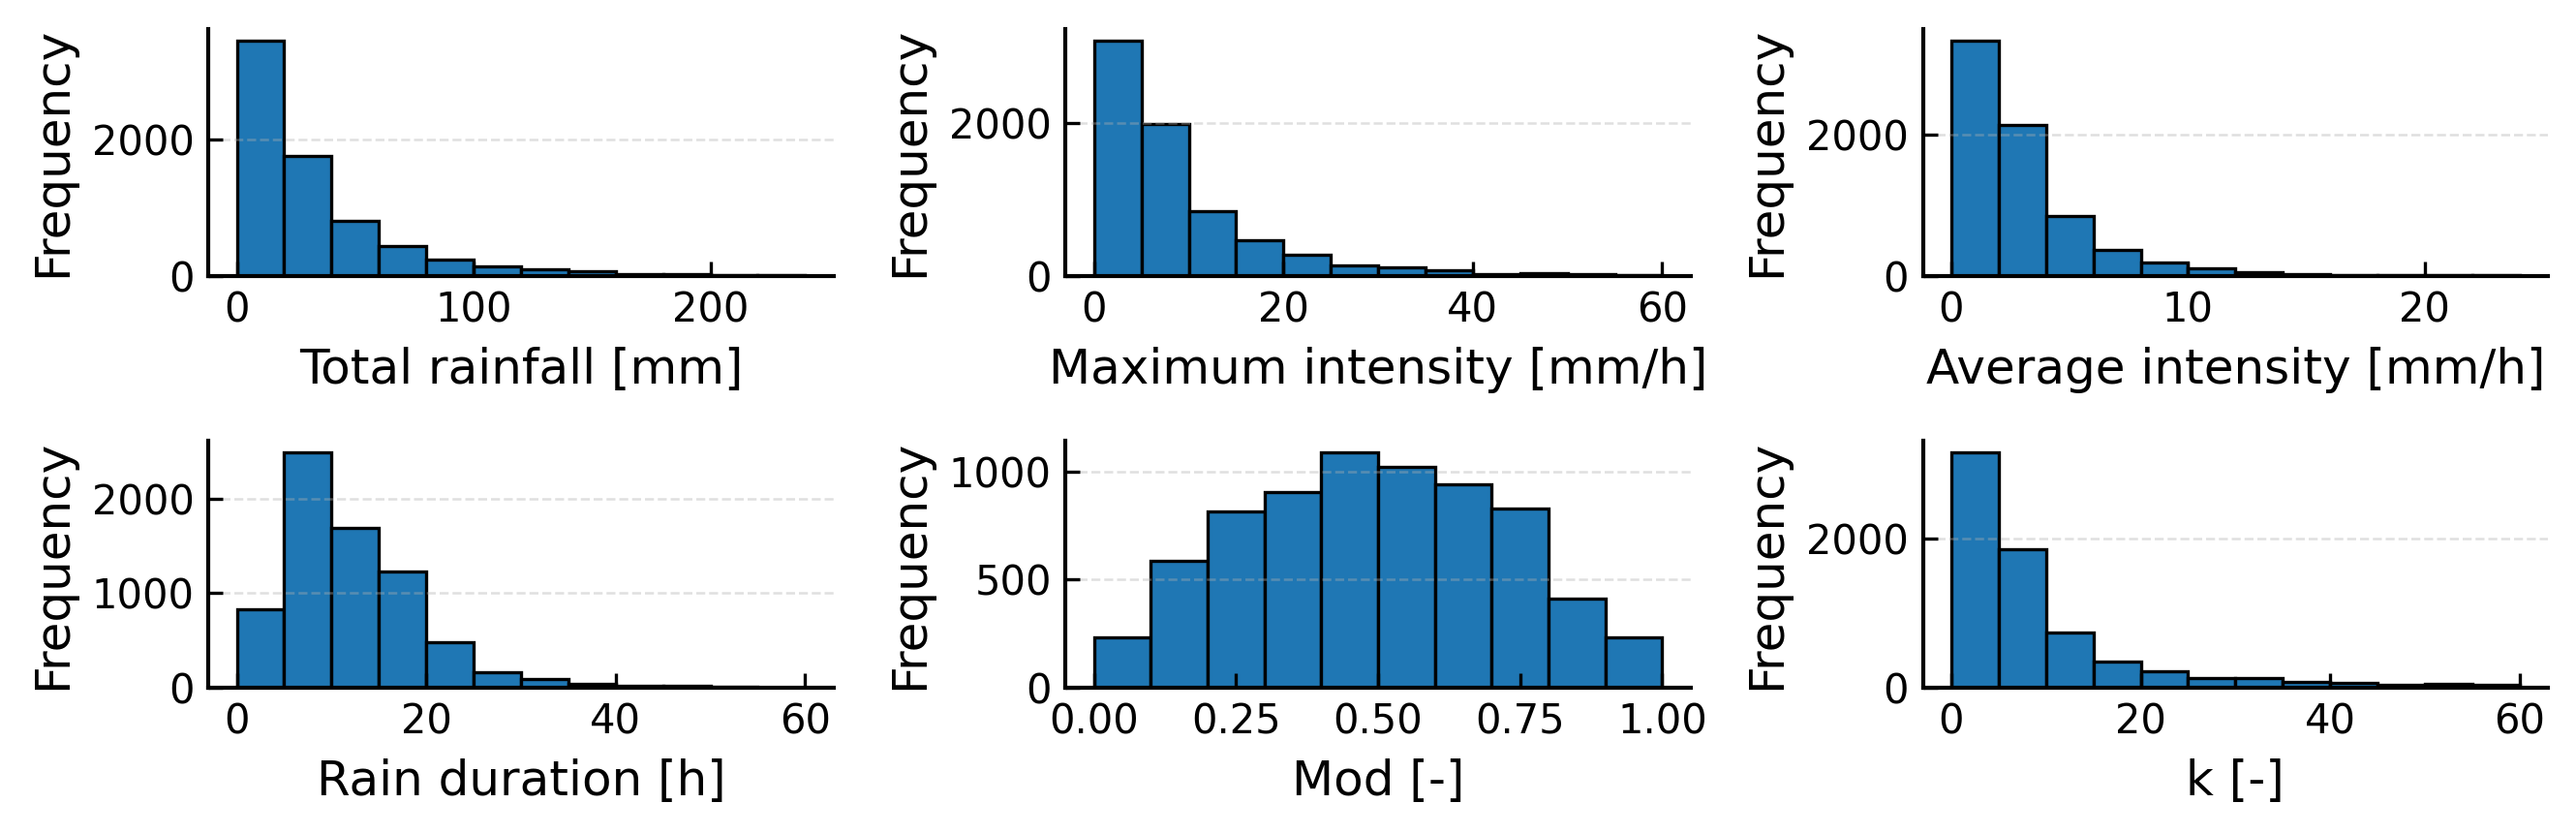

In [8]:
FILE_PATH = "BusanRainfall Results.xlsx"
SHEET_NAME = 0

OUT_NAME = "FIG_Hist_6vars"

DISPLAY = {
    "total_rainfall": ("Total rainfall", "mm"),
    "max_intensity": ("Maximum intensity", "mm/h"),
    "average_intensity": ("Average intensity", "mm/h"),
    "rain_duration": ("Rain duration", "h"),
    "mod": ("Mod", "-"),
    "k": ("k", "-"),
}

VAR_BINS = {
    "total_rainfall": (0, 240, 20),
    "max_intensity": (0, 60, 5),
    "average_intensity": (0, 24, 2),
    "rain_duration": (0, 60, 5),
    "mod": (0, 1, 0.1),
    "k": (0, 60, 5),
}

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
    "grid.linewidth": 0.6,
    "grid.alpha": 0.4,
    "figure.dpi": 300,
})

def main():
    df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)

    order = [
        "total_rainfall", "max_intensity", "average_intensity",
        "rain_duration", "mod", "k"
    ]

    fig, axes = plt.subplots(2, 3, figsize=(9, 3))
    axes = axes.ravel()

    for ax, key in zip(axes, order):
        lo, hi, bw = VAR_BINS[key]
        bins = np.arange(lo, hi + bw, bw)

        s = pd.to_numeric(df[key], errors="coerce")
        s = s[(s >= lo) & (s <= hi)].dropna()

        label, unit = DISPLAY[key]
        xlab = f"{label} [{unit}]" if unit else label

        ax.hist(s.values, bins=bins, edgecolor="black", linewidth=0.8)
        ax.set_xlabel(xlab)
        ax.set_ylabel("Frequency")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", linestyle="--")
        ax.tick_params(direction="in")

    plt.tight_layout()
    fig.savefig(f"{OUT_NAME}.pdf", bbox_inches="tight")
    fig.savefig(f"{OUT_NAME}.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    main()

C:\Users\NSEONU\AppData\Local\Temp\ipykernel_24988\3721167586.py:70: RuntimeWarning: overflow encountered in exp
  Tr_12 = 1.0 + 1.0 / (np.exp(Delta) - 1.0)
C:\Users\NSEONU\AppData\Local\Temp\ipykernel_24988\3721167586.py:71: RuntimeWarning: overflow encountered in exp
  Tr_23 = 1.0 + 1.0 / (np.exp(Delta / 2.0) - 1.0)


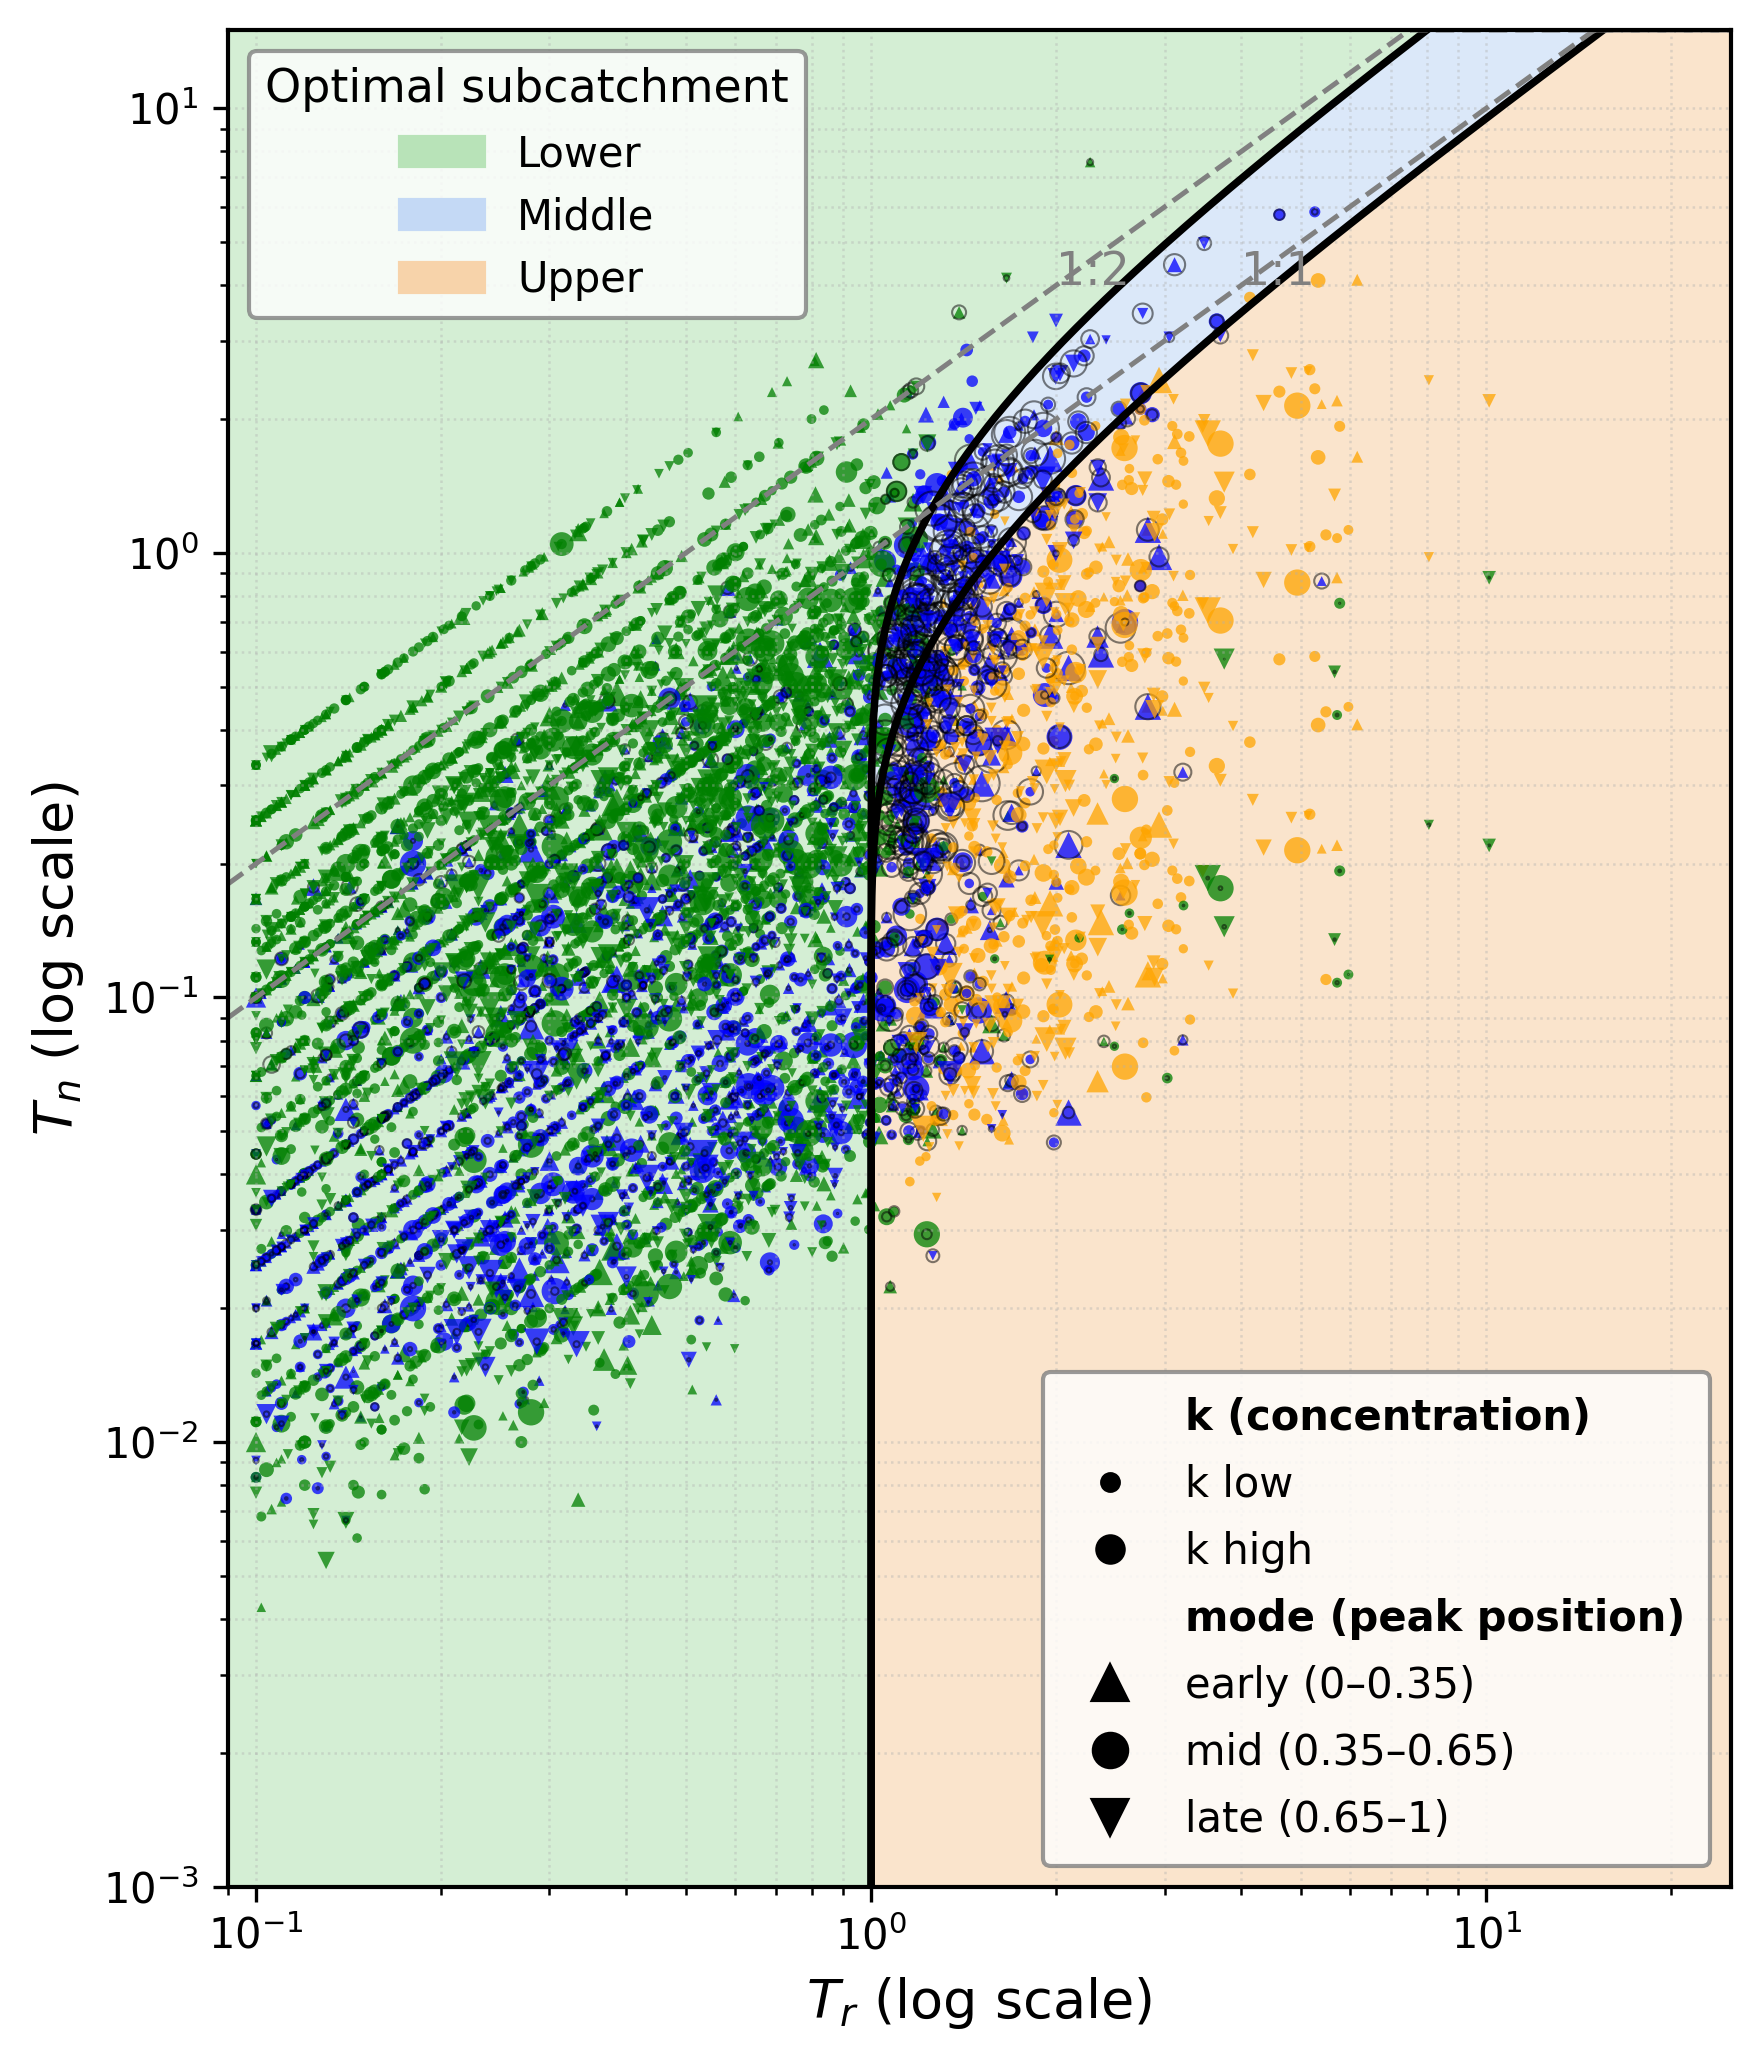

In [ ]:
TN_CHOICE = "all"   # 1 / 4 / 10 / all

FILE_PATH = "BusanRainfall Results.xlsx"
SAVE_PATH = f"regime_background_with_scatter_log({TN_CHOICE}).pdf"
DEFAULT_SMAX = 300.0

COLOR_MAP = {"BOT": "green", "MID": "blue", "TOP": "orange"}

Tr_min, Tr_max = 9e-2, 25.0
Tn_min, Tn_max = 1e-3, 15.0

S_MIN, S_MAX = 5, 40

MOD_BINS   = [0.0, 0.35, 0.65, 1.01]
MOD_MARKS  = ["^", "o", "v"]   # early / mid / late
MOD_LABELS = ["early (0–0.35)", "mid (0.35–0.65)", "late (0.65–1)"]

REL_MIN, REL_MAX = 0.0, 20.0
RING_MIN, RING_MAX = 0.0, 200.0

def parse_smax_from_filename(path: str, default_val: float = 300.0) -> float:
    m = re.search(r"_Smax([0-9]+\.?[0-9]*)", os.path.basename(path), flags=re.IGNORECASE)
    if m:
        try:
            return float(m.group(1))
        except Exception:
            pass
    return float(default_val)

def size_from_k(k, k_lo, k_hi):
    k_clip = np.clip((k - k_lo) / (k_hi - k_lo), 0, 1)
    return S_MIN + (S_MAX - S_MIN) * k_clip

def marker_from_mod(m):
    for b0, b1, mk in zip(MOD_BINS[:-1], MOD_BINS[1:], MOD_MARKS):
        if b0 <= m < b1:
            return mk
    return MOD_MARKS[-1]

def main():
    df = pd.read_excel(FILE_PATH)

    i_col   = "average_intensity"
    tr_col  = "rain_duration"
    tn_col  = "tn_group"
    k_col   = "k"
    mod_col = "mod"

    top_col = "강우 top"
    mid_col = "강우 mid"
    bot_col = "강우 bot"

    rel_col = "regret"

    if str(TN_CHOICE).lower() != "all":
        tn_target = float(TN_CHOICE)
        tn_values = pd.to_numeric(df[tn_col], errors="coerce")
        df = df[(tn_values >= tn_target - 0.1) & (tn_values < tn_target + 0.1)]

    Smax_value = parse_smax_from_filename(FILE_PATH, DEFAULT_SMAX)

    n_Tn, n_Tr = 400, 400
    Tr = np.logspace(np.log10(Tr_min), np.log10(Tr_max), n_Tr)
    Tn = np.logspace(np.log10(Tn_min), np.log10(Tn_max), n_Tn)
    Tr_grid, Tn_grid = np.meshgrid(Tr, Tn)

    Delta = 2.0 / Tn
    Tr_12 = 1.0 + 1.0 / (np.exp(Delta) - 1.0)
    Tr_23 = 1.0 + 1.0 / (np.exp(Delta / 2.0) - 1.0)
    Tr_12_2D = Tr_12[:, None]
    Tr_23_2D = Tr_23[:, None]

    region = np.zeros_like(Tr_grid, dtype=int)
    region[Tr_grid < Tr_12_2D] = 1
    region[(Tr_grid >= Tr_12_2D) & (Tr_grid < Tr_23_2D)] = 2
    region[Tr_grid >= Tr_23_2D] = 3

    fig, ax = plt.subplots(figsize=(6, 7))
    colors = ["#b8e3b8", "#c4d9f5", "#f7d3aa"]
    ax.contourf(Tr_grid, Tn_grid, region,
                levels=[0.5, 1.5, 2.5, 3.5], colors=colors, alpha=0.6)
    ax.plot(Tr_12, Tn, "k-", lw=1.8)
    ax.plot(Tr_23, Tn, "k-", lw=1.8)

    Tn_11 = np.clip(Tr, Tn_min, Tn_max)
    Tn_12 = np.clip(2*Tr, Tn_min, Tn_max)
    ax.plot(Tr, Tn_11, "--", color="gray", lw=1.2)
    ax.plot(Tr, Tn_12, "--", color="gray", lw=1.2)
    ax.text(4.0, 4.0, "1:1", fontsize=11, color="gray")
    ax.text(2.0, 4.0, "1:2", fontsize=11, color="gray")

    i_val  = pd.to_numeric(df[i_col], errors="coerce").to_numpy(dtype=float)
    tr_val = pd.to_numeric(df[tr_col], errors="coerce").to_numpy(dtype=float)
    tn_val = pd.to_numeric(df[tn_col], errors="coerce").to_numpy(dtype=float)
    k_val  = pd.to_numeric(df[k_col], errors="coerce").to_numpy(dtype=float)
    mod    = pd.to_numeric(df[mod_col], errors="coerce").to_numpy(dtype=float)
    rel    = pd.to_numeric(df[rel_col], errors="coerce").to_numpy(dtype=float)

    v_top = pd.to_numeric(df[top_col], errors="coerce").to_numpy(dtype=float)
    v_mid = pd.to_numeric(df[mid_col], errors="coerce").to_numpy(dtype=float)
    v_bot = pd.to_numeric(df[bot_col], errors="coerce").to_numpy(dtype=float)

    Tr_val = np.maximum(i_val * 6.0 * tr_val / Smax_value, 1e-6)
    Tn_val = np.maximum(i_val * 6.0 * tn_val * 2.0 / Smax_value, 1e-6)

    arr = np.vstack([v_top, v_mid, v_bot]).T
    best_idx = np.nanargmax(arr, axis=1)
    winners = np.array(["TOP", "MID", "BOT"], dtype=object)[best_idx]

    valid = np.isfinite(Tr_val) & np.isfinite(Tn_val) & (Tr_val > 0) & (Tn_val > 0) & np.isfinite(k_val) & np.isfinite(mod)
    Tr_val = Tr_val[valid]; Tn_val = Tn_val[valid]
    k_val  = k_val[valid];  mod    = np.clip(mod[valid], 0, 1)
    rel    = rel[valid]
    winners = winners[valid]

    k_valid = k_val[np.isfinite(k_val)]
    k_lo = np.percentile(k_valid, 2) if k_valid.size else 0.0
    k_hi = np.percentile(k_valid, 98) if k_valid.size else 1.0
    if k_hi <= k_lo:
        k_hi = k_lo + 1.0

    s_vals = size_from_k(k_val, k_lo, k_hi)
    face_colors = np.vectorize(lambda w: COLOR_MAP.get(w, "black"))(winners)
    markers = np.vectorize(marker_from_mod)(mod)

    for b0, b1, mk in zip(MOD_BINS[:-1], MOD_BINS[1:], MOD_MARKS):
        msk = (mod >= b0) & (mod < b1)
        if not np.any(msk):
            continue
        ax.scatter(Tr_val[msk], Tn_val[msk],
                   s=s_vals[msk], marker=mk, c=face_colors[msk],
                   alpha=0.75, edgecolors="none")

        rel_sub = rel[msk]
        ring_m = np.isfinite(rel_sub) & (rel_sub > 0)
        if np.any(ring_m):
            rel_scaled = (rel_sub[ring_m] - REL_MIN) / (REL_MAX - REL_MIN)
            rel_scaled = np.clip(rel_scaled, 0.0, 1.0)
            ring_sizes = RING_MIN + (RING_MAX - RING_MIN) * rel_scaled

            ax.scatter(Tr_val[msk][ring_m], Tn_val[msk][ring_m],
                       s=ring_sizes, marker="o",
                       facecolors="none", edgecolors="k",
                       linewidths=0.5, alpha=0.5)

    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlim(Tr_min, Tr_max); ax.set_ylim(Tn_min, Tn_max)
    ax.set_xlabel(r"$T_r$ (log scale)", fontsize=13)
    ax.set_ylabel(r"$T_n$ (log scale)", fontsize=13)
    ax.grid(True, which="both", ls=":", alpha=0.4)

    patch_lower  = mpatches.Patch(color=colors[0], label="Lower")
    patch_middle = mpatches.Patch(color=colors[1], label="Middle")
    patch_upper  = mpatches.Patch(color=colors[2], label="Upper")
    region_legend = ax.legend(handles=[patch_lower, patch_middle, patch_upper],
                              loc="upper left", fontsize=10, frameon=True,
                              facecolor="white", edgecolor="gray",
                              title="Optimal subcatchment")

    ms_low  = max(4.0, np.sqrt(size_from_k(k_lo, k_lo, k_hi)))
    ms_high = max(4.0, np.sqrt(size_from_k(k_hi, k_lo, k_hi)))
    legend_handles = [
        Line2D([], [], marker='o', linestyle='none', markerfacecolor='none',
               markeredgecolor='none', label='k (concentration)'),
        Line2D([], [], marker='o', linestyle='none', markersize=ms_low,
               markerfacecolor='black', markeredgecolor='black', label='k low'),
        Line2D([], [], marker='o', linestyle='none', markersize=ms_high,
               markerfacecolor='black', markeredgecolor='black', label='k high'),
        Line2D([], [], marker='o', linestyle='none', markerfacecolor='none',
               markeredgecolor='none', label='mode (peak position)'),
    ]
    legend_handles += [
        Line2D([], [], color='black', marker=mk, linestyle='none', markersize=8, label=lab)
        for mk, lab in zip(MOD_MARKS, MOD_LABELS)
    ]

    combined_legend = ax.legend(handles=legend_handles, loc="lower right",
                               frameon=True, facecolor="white", edgecolor="gray",
                               fontsize=10, handlelength=2.0,
                               handletextpad=0.8, labelspacing=0.6, borderpad=0.6)

    for t in combined_legend.get_texts():
        if t.get_text() in ("k (concentration)", "mode (peak position)"):
            t.set_fontweight("bold")

    ax.add_artist(region_legend)

    plt.tight_layout()
    plt.savefig(SAVE_PATH, dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    main()


In [19]:
XLSX_PATH = "BusanRainfall Results.xlsx"
GROUP_VAR = "total_rainfall"  # k mod total_rainfall
GROUP_NAME = "total rainfall"
unit = "mm"

BINS = [(None, 25), (25, 50), (50, 75), (75, 100), (100, 150), (150, None)] # Tr
#BINS = [(0, 4), (4, 8), (8, 15), (15, 30), (30, None)] # k
#BINS = [(None, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, None)] # mod

OUTDIR = os.path.join(os.path.dirname(XLSX_PATH), f"{GROUP_VAR}_bins")
os.makedirs(OUTDIR, exist_ok=True)

DEBUG = False

In [20]:
def bin_label(lo, hi):
    if lo is None and hi is None: return "all"
    if lo is None: return f"<{hi:g}"
    if hi is None: return f"{lo:g}+"
    return f"{lo:g}–{hi:g}"

def in_bin(val, lo, hi):
    if pd.isna(val): return False
    if lo is not None and val < lo - 1e-12: return False
    if hi is not None and not (val < hi - 1e-12): return False
    return True

def argmax_loc(vals_by_loc: dict) -> str:
    return max(vals_by_loc, key=vals_by_loc.get)

df = pd.read_excel(XLSX_PATH)
required_cols = [
    "강우명","k","mode","tn_group",
    "강우 top","강우 mid","강우 bot",
    "일정한 강우 top","일정한 강우 mid","일정한 강우 bot"
]
actual_dict = {"top":"강우 top","mid":"강우 mid","bot":"강우 bot"}
uniform_dict = {"top":"일정한 강우 top","mid":"일정한 강우 mid","bot":"일정한 강우 bot"}

def compute_row_metrics(r: pd.Series) -> pd.Series:
    a_vals = {k: float(r[v]) for k, v in actual_dict.items()}
    u_vals = {k: float(r[v]) for k, v in uniform_dict.items()}
    actual_best_loc = argmax_loc(a_vals)
    uniform_best_loc = argmax_loc(u_vals)
    actual_at_uniform = a_vals[uniform_best_loc]
    regret_abs = a_vals[actual_best_loc] - actual_at_uniform
    regret_rel = (regret_abs / (a_vals[actual_best_loc] + 1e-9)) if a_vals[actual_best_loc] != 0 else 0.0
    return pd.Series({
        "actual_best_loc": actual_best_loc,
        "uniform_best_loc": uniform_best_loc,
        "changed": uniform_best_loc != actual_best_loc,
        "actual_best_val": a_vals[actual_best_loc],
        "uniform_best_val": u_vals[uniform_best_loc],
        "actual_at_uniform": actual_at_uniform,
        "regret_abs": regret_abs,
        "regret_rel": regret_rel
    })

metrics = df.apply(compute_row_metrics, axis=1)
res = pd.concat([df, metrics], axis=1)

def _tn_sort_key(s):
    if pd.isna(s): return (2, "ZZZ")
    s_str = str(s).strip()
    m = re.match(r"^\s*Tn\s*(\d+)\s*$", s_str, flags=re.IGNORECASE)
    if m: return (0, int(m.group(1)))
    try: return (1, float(s_str))
    except Exception: return (2, s_str)

tn_groups = sorted(res["tn_group"].dropna().unique().tolist(), key=_tn_sort_key)

all_tn_summaries = []
order_labels = [bin_label(lo, hi) for lo, hi in BINS]

for tg in tn_groups:
    sub_all = res[res["tn_group"] == tg].copy()
    if sub_all.empty: continue

    rows = []
    gv = pd.to_numeric(sub_all[GROUP_VAR], errors="coerce")

    for lo, hi in BINS:
        lab = bin_label(lo, hi)
        m_bin = gv.apply(lambda v: in_bin(v, lo, hi))
        sub_bin = sub_all.loc[m_bin]
        sub_bin_changed = sub_all.loc[m_bin & sub_all["changed"]]

        def qstats(x):
            if len(x) == 0: return (np.nan, np.nan, np.nan)
            xx = np.asarray(x, float)
            return (float(np.nanpercentile(xx, 10)),
                    float(np.nanpercentile(xx, 50)),
                    float(np.nanpercentile(xx, 90)))

        p10_all, p50_all, p90_all = qstats(sub_bin["regret_abs"])
        p10_chg, p50_chg, p90_chg = qstats(sub_bin_changed["regret_abs"])

        regret_max_all = float(np.nanmax(sub_bin["regret_abs"])) if len(sub_bin) else np.nan
        regret_max_chg = float(np.nanmax(sub_bin_changed["regret_abs"])) if len(sub_bin_changed) else np.nan

        rows.append({
            "tn_group": tg,
            f"{GROUP_VAR}_bin": lab,
            "n_all": int(len(sub_bin)),
            "n_changed": int(len(sub_bin_changed)),
            "change_ratio(%)": float(sub_bin["changed"].mean() * 100.0) if len(sub_bin) else np.nan,
            "regret_mean_all": float(sub_bin["regret_abs"].mean()) if len(sub_bin) else np.nan,
            "regret_median_all": float(sub_bin["regret_abs"].median()) if len(sub_bin) else np.nan,
            "regret_mean_changed": float(sub_bin_changed["regret_abs"].mean()) if len(sub_bin_changed) else np.nan,
            "regret_median_changed": float(sub_bin_changed["regret_abs"].median()) if len(sub_bin_changed) else np.nan,
            "p10_all": p10_all, "p50_all": p50_all, "p90_all": p90_all,
            "p10_chg": p10_chg, "p50_chg": p50_chg, "p90_chg": p90_chg,
            "regret_max_all": regret_max_all,
            "regret_max_changed": regret_max_chg,
        })

    tn_summary = pd.DataFrame(rows).set_index(f"{GROUP_VAR}_bin").reindex(order_labels).reset_index()
    all_tn_summaries.append(tn_summary)

def draw_p1090_boxes(ax, x, p10, p90, width=0.6,
                     facecolor='lightgray', edgecolor='tab:gray',
                     alpha=0.5, linewidth=1.5, zorder=2):
    for xi, lo, hi in zip(x, p10, p90):
        if np.isfinite(lo) and np.isfinite(hi) and hi >= lo:
            h = hi - lo
            ax.add_patch(Rectangle(
                (xi - width/2, lo), width, h,
                facecolor=facecolor, edgecolor=edgecolor,
                alpha=alpha, linewidth=linewidth, zorder=zorder
            ))

def _safe_max(x, default=1.0):
    try:
        m = np.nanmax(x)
        if not np.isfinite(m) or m <= 0: return default
        return float(m)
    except Exception:
        return default

max_change_all_tn = _safe_max([np.nanmax(df_["change_ratio(%)"].to_numpy()) for df_ in all_tn_summaries], 1.0)
max_regret_all    = _safe_max([np.nanmax(df_["regret_max_all"].to_numpy()) for df_ in all_tn_summaries], 1.0)
max_regret_chg    = _safe_max([np.nanmax(df_["regret_max_changed"].to_numpy()) for df_ in all_tn_summaries], 1.0)

YLIM_CHANGE     = (0, max_change_all_tn * 1.3)
YLIM_REGRET_ALL = (0, max_regret_all * 1.1)
YLIM_REGRET_CHG = (0, max_regret_chg * 1.1)

for tn_summary in all_tn_summaries:
    tg = str(tn_summary["tn_group"].iloc[0])

    labels = tn_summary[f"{GROUP_VAR}_bin"].tolist()
    vals = tn_summary["change_ratio(%)"].to_numpy()
    counts_all = tn_summary["n_all"].to_numpy()

    plt.figure(figsize=(4, 2.4))
    ax = plt.gca()
    bars = ax.bar(labels, np.nan_to_num(vals, nan=0.0), width=0.7, edgecolor="k", linewidth=0.8)
    ax.set_xlabel(f"{GROUP_NAME} ({unit})" if unit else f"{GROUP_NAME}")
    ax.set_ylabel("Location change ratio (%)")
    ax.set_ylim(*YLIM_CHANGE)
    ax.tick_params(axis='both', labelsize=8)

    ymax = YLIM_CHANGE[1]
    for i, (b, v, n) in enumerate(zip(bars, vals, counts_all)):
        top = b.get_height()
        if np.isfinite(v):
            ax.text(i, top + 0.01 * ymax, f"{v:.1f}%", ha="center", va="bottom", fontsize=8, color='black')
            ax.text(i, ymax, f"n={int(n)}", ha="center", va="bottom", fontsize=8, color='dimgray')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"changed_ratio_by_{GROUP_VAR}_bin__{tg}.pdf"), dpi=300)
    plt.close()

    p10_all = tn_summary["p10_all"].to_numpy()
    p50_all = tn_summary["p50_all"].to_numpy()
    p90_all = tn_summary["p90_all"].to_numpy()
    mean_all = tn_summary["regret_mean_all"].to_numpy()
    max_all  = tn_summary["regret_max_all"].to_numpy()

    x = np.arange(len(labels))

    plt.figure(figsize=(4, 2.4))
    ax = plt.gca()

    draw_p1090_boxes(ax, x, p10_all, p90_all,
                    width=0.6, facecolor='lightgray',
                    edgecolor='tab:gray', alpha=0.5, linewidth=1.5, zorder=2)

    ax.scatter(x, mean_all, label="Mean", marker='_', s=580, color='tab:orange', linewidths=2, zorder=3)
    ax.scatter(x, max_all,  label="Max",  marker='_', s=580, color='tab:blue', linewidths=2, zorder=4)

    ax.set_xticks(x, labels)
    ax.set_xlabel(f"{GROUP_NAME} ({unit})" if unit else f"{GROUP_NAME}")
    ax.set_ylabel("Regret (%)")
    ax.set_ylim(*YLIM_REGRET_ALL)
    ax.tick_params(axis='both', labelsize=8)

    box_proxy = Rectangle((0,0), 1, 1, facecolor='lightgray', edgecolor='tab:gray', alpha=0.5)

    ymax = YLIM_REGRET_ALL[1]
    for i in range(len(x)):
        if np.isfinite(mean_all[i]): ax.text(x[i]+0.08, mean_all[i], f"{mean_all[i]:.1f}", color='tab:orange', ha='center', va='bottom', fontsize=8)
        if np.isfinite(max_all[i]):  ax.text(x[i], max_all[i],  f"{max_all[i]:.1f}",  color='tab:blue', ha='center', va='bottom', fontsize=8)
        if np.isfinite(p90_all[i]):  ax.text(x[i]-0.08, p90_all[i], f"{p90_all[i]:.1f}", color='gray', ha='center', va='bottom', fontsize=8, style='italic')
        anchor = max_all[i] if np.isfinite(max_all[i]) else (p90_all[i] if np.isfinite(p90_all[i]) else (p50_all[i] if np.isfinite(p50_all[i]) else 0.0))
        ax.text(x[i], ymax, f"n={int(counts_all[i])}", ha="center", va="bottom", fontsize=8, color='dimgray')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"regret_whisker_by_{GROUP_VAR}_bin__{tg}.pdf"), dpi=300)
    plt.close()

    p10_chg = tn_summary["p10_chg"].to_numpy()
    p50_chg = tn_summary["p50_chg"].to_numpy()
    p90_chg = tn_summary["p90_chg"].to_numpy()
    mean_chg = tn_summary["regret_mean_changed"].to_numpy()
    max_chg  = tn_summary["regret_max_changed"].to_numpy()
    counts_chg = tn_summary["n_changed"].to_numpy()

    plt.figure(figsize=(4, 2.4))
    ax = plt.gca()

    draw_p1090_boxes(ax, x, p10_chg, p90_chg,
                    width=0.6, facecolor='lightgray',
                    edgecolor='tab:gray', alpha=0.5, linewidth=1.5, zorder=2)

    ax.scatter(x, mean_chg, label="Mean", marker='_', s=580, color='tab:orange', linewidths=2, zorder=3)
    ax.scatter(x, max_chg,  label="Max",  marker='_', s=580, color='tab:blue', linewidths=2, zorder=4)

    ax.set_xticks(x, labels)
    ax.set_xlabel(f"{GROUP_NAME} ({unit})" if unit else f"{GROUP_NAME}")
    ax.set_ylabel("Regret (%)")
    ax.set_ylim(*YLIM_REGRET_CHG)
    ax.tick_params(axis='both', labelsize=8)

    box_proxy = Rectangle((0,0), 1, 1, facecolor='lightgray', edgecolor='tab:gray', alpha=0.5)

    ymax = YLIM_REGRET_CHG[1]
    for i in range(len(x)):
        if np.isfinite(mean_chg[i]): ax.text(x[i]+0.08, mean_chg[i], f"{mean_chg[i]:.1f}", color='tab:orange', ha='center', va='bottom', fontsize=8)
        if np.isfinite(max_chg[i]):  ax.text(x[i], max_chg[i],  f"{max_chg[i]:.1f}",  color='tab:blue', ha='center', va='bottom', fontsize=8)
        if np.isfinite(p90_chg[i]):  ax.text(x[i]-0.08, p90_chg[i], f"{p90_chg[i]:.1f}", color='gray', ha='center', va='bottom', fontsize=8, style='italic')
        anchor = max_chg[i] if np.isfinite(max_chg[i]) else (p90_chg[i] if np.isfinite(p90_chg[i]) else (p50_chg[i] if np.isfinite(p50_chg[i]) else 0.0))
        ax.text(x[i], ymax, f"n={int(counts_chg[i])}", ha="center", va="bottom", fontsize=8, color='dimgray')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"regret_whisker_by_{GROUP_VAR}_bin_changedonly__{tg}.pdf"), dpi=300)
    plt.close()

summary_xlsx = os.path.join(OUTDIR, f"summary_by_tn__{GROUP_VAR}_bins.xlsx")
if all_tn_summaries:
    with pd.ExcelWriter(summary_xlsx, engine="xlsxwriter") as w:
        for tbl in all_tn_summaries:
            sheet = f"tn_{str(tbl['tn_group'].iloc[0])}"
            if len(sheet) > 30: sheet = sheet[:30]
            tbl.to_excel(w, sheet_name=sheet, index=False)
print("[완료] 저장 폴더:", OUTDIR)
print("[완료] 요약 엑셀:", summary_xlsx if all_tn_summaries else "요약 없음")

[완료] 저장 폴더: total_rainfall_bins
[완료] 요약 엑셀: total_rainfall_bins\summary_by_tn__total_rainfall_bins.xlsx


In [22]:
_LOC_MAP = {
    "top":"top", "upper":"top", "상":"top", "상류":"top",
    "mid":"mid", "middle":"mid", "중":"mid", "중류":"mid",
    "bot":"bot", "bottom":"bot", "하":"bot", "하류":"bot",
}
def normalize_loc(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    return _LOC_MAP.get(s, s)

TRANSITIONS = [
    ("top","mid"), ("top","bot"),
    ("mid","top"), ("mid","bot"),
    ("bot","top"), ("bot","mid"),
]
COLOR_MAP = {
    ("top","mid"): "#004272",
    ("top","bot"): "#0e8fff",
    ("mid","top"): "#FF00FF",
    ("mid","bot"): "#78c0ff",
    ("bot","top"): "#D900FF",
    ("bot","mid"): "#319b00",
}

df = pd.read_excel(XLSX_PATH)
df.columns = df.columns.astype(str).str.strip()

need = {"tn_group", GROUP_VAR, "일정기준", "실기준"}

df[GROUP_VAR] = pd.to_numeric(df[GROUP_VAR], errors="coerce")

df["uniform_loc"] = df["일정기준"].apply(normalize_loc)
df["actual_loc"]  = df["실기준"].apply(normalize_loc)
df["changed"] = (df["uniform_loc"] != df["actual_loc"]) & df["uniform_loc"].notna() & df["actual_loc"].notna()

tn_groups = sorted(df["tn_group"].dropna().unique().tolist(), key=_tn_sort_key)

order_labels = [bin_label(lo, hi) for lo, hi in BINS]

all_tn_tables = []
for tg in tn_groups:
    sub = df[df["tn_group"] == tg].copy()
    gv = pd.to_numeric(sub[GROUP_VAR], errors="coerce")
    rows = []
    for lo, hi in BINS:
        lab = bin_label(lo, hi)
        mask_bin = gv.apply(lambda v: in_bin(v, lo, hi))
        bin_df = sub.loc[mask_bin].copy()
        n_all = int(len(bin_df))
        if n_all == 0:
            rows.append({
                "tn_group": tg, f"{GROUP_VAR}_bin": lab,
                "n_all": 0, "n_changed": 0, "change_ratio(%)": 0.0,
                **{f"{a}->{b}": 0.0 for (a,b) in TRANSITIONS}
            })
            continue

        n_changed = int(bin_df["changed"].sum())
        change_ratio = (n_changed / n_all) * 100.0

        trans_perc = {t: 0.0 for t in TRANSITIONS}
        changed_df = bin_df[bin_df["changed"] == True]
        if not changed_df.empty:
            for (u, a), cnt in changed_df.groupby(["uniform_loc","actual_loc"]).size().items():
                if (u != a) and ((u, a) in trans_perc):
                    trans_perc[(u, a)] += (cnt / n_all) * 100.0

        rows.append({
            "tn_group": tg, f"{GROUP_VAR}_bin": lab,
            "n_all": n_all, "n_changed": n_changed,
            "change_ratio(%)": change_ratio,
            **{f"{a}->{b}": trans_perc[(a,b)] for (a,b) in TRANSITIONS}
        })

    tbl = pd.DataFrame(rows).set_index(f"{GROUP_VAR}_bin").reindex(order_labels).reset_index()
    all_tn_tables.append(tbl)

max_change = _safe_max([np.nanmax(t["change_ratio(%)"].to_numpy()) for t in all_tn_tables], 1.0)
YLIM_CHANGE = (0, max_change * 1.3)

for tbl in all_tn_tables:
    tg = str(tbl["tn_group"].iloc[0])
    labels = tbl[f"{GROUP_VAR}_bin"].tolist()
    vals   = tbl["change_ratio(%)"].to_numpy(dtype=float)
    counts = tbl["n_all"].to_numpy(dtype=int)

    x = np.arange(len(labels))
    width = 0.7

    plt.figure(figsize=(4, 2.4))
    ax = plt.gca()

    vals_plot = np.nan_to_num(vals, nan=0.0)
    bars = ax.bar(labels, vals_plot, width=width, edgecolor="k", linewidth=0.8, zorder=1)

    ax.set_xlabel(f"{GROUP_NAME} ({unit})" if unit else f"{GROUP_NAME}")
    ax.set_ylabel("Location change ratio (%)")
    ax.set_ylim(*YLIM_CHANGE)
    ax.tick_params(axis='both', labelsize=8)

    any_stack = False
    for i, lab in enumerate(labels):
        bottom = 0.0
        for t in TRANSITIONS:
            h = float(tbl.loc[tbl[f"{GROUP_VAR}_bin"] == lab, f"{t[0]}->{t[1]}"].values[0])
            if h <= 0:
                continue
            ax.bar(i, h, width=width, bottom=bottom,
                   color=COLOR_MAP[t], alpha=0.78, edgecolor="k", linewidth=0.3, zorder=2)
            bottom += h
            any_stack = True

    ymax = YLIM_CHANGE[1]
    for i, (b, v, n) in enumerate(zip(bars, vals_plot, counts)):
        top = b.get_height()
        if np.isfinite(v) and v > 0:
            ax.text(i, top + 0.01 * ymax, f"{v:.1f}%", ha="center", va="bottom", fontsize=8, color='black', zorder=5)
        ax.text(i, ymax, f"n={int(n)}", ha="center", va="bottom", fontsize=8, color='dimgray', zorder=5)

    if any_stack:
        handles = []
        for t in TRANSITIONS:
            colname = f"{t[0]}->{t[1]}"
            if (tbl[colname] > 0).any():
                handles.append(mpatches.Patch(facecolor=COLOR_MAP[t], edgecolor="k", label=colname))
        if handles:
            ax.legend(handles=handles, frameon=False, ncol=3, fontsize=8, loc="upper left")

    plt.tight_layout()
    out = os.path.join(OUTDIR, f"changed_ratio_by_{GROUP_VAR}_bin__{tg}.pdf")
    plt.savefig(out, dpi=300)
    plt.close()
    print("[저장]", out)


[저장] total_rainfall_bins\changed_ratio_by_total_rainfall_bin__0.5.pdf
[저장] total_rainfall_bins\changed_ratio_by_total_rainfall_bin__2.0.pdf
[저장] total_rainfall_bins\changed_ratio_by_total_rainfall_bin__5.0.pdf
